In [0]:
!nvidia-smi

Fri May 29 18:59:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 133kB 8.3MB/s 
     |████████████████████████████████| 92kB 10.1MB/s 


In [0]:
!pip install -qq transformers

     |████████████████████████████████| 665kB 8.7MB/s 
     |████████████████████████████████| 3.8MB 24.9MB/s 
     |████████████████████████████████| 1.1MB 57.8MB/s 
     |████████████████████████████████| 890kB 54.1MB/s 


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import transformers
import numpy as np
import torch

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from torch import nn, optim
from pylab import rcParams
from matplotlib import rc
from textwrap import wrap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Config
Setting plot settings and constance


In [0]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
COLORS = ["#008cff", "#ffc800", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))
rcParams['figure.figsize'] = 12, 8

MAX_LEN = 512
BATCH_SIZE = 16
RANDOM_SEED = 17
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Data loading


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = '/content/gdrive/My Drive/data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# pd.set_option('display.max_columns', None)
df = pd.read_csv(PATH + 'df_final_labeled.csv')

In [0]:
df = df.drop_duplicates(subset='text', keep="first")

In [0]:
df['label'] = df['label'].map({'Fake': 1, 'Real': 0})

In [0]:
df = df[['text', 'label']]

In [0]:
df.head()

,text,label
0,Work is available — but it is often unsteady a...,0
1,"For some struggling Americans, the arrival of ...",0
2,The Small Business Administration has run out ...,0
3,Many governors and health experts are more cau...,0
4,News outlets are also grappling with how to co...,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430 entries, 0 to 5429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5430 non-null   object
 1   label   5430 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 85.0+ KB


Let's look at label balance in out data


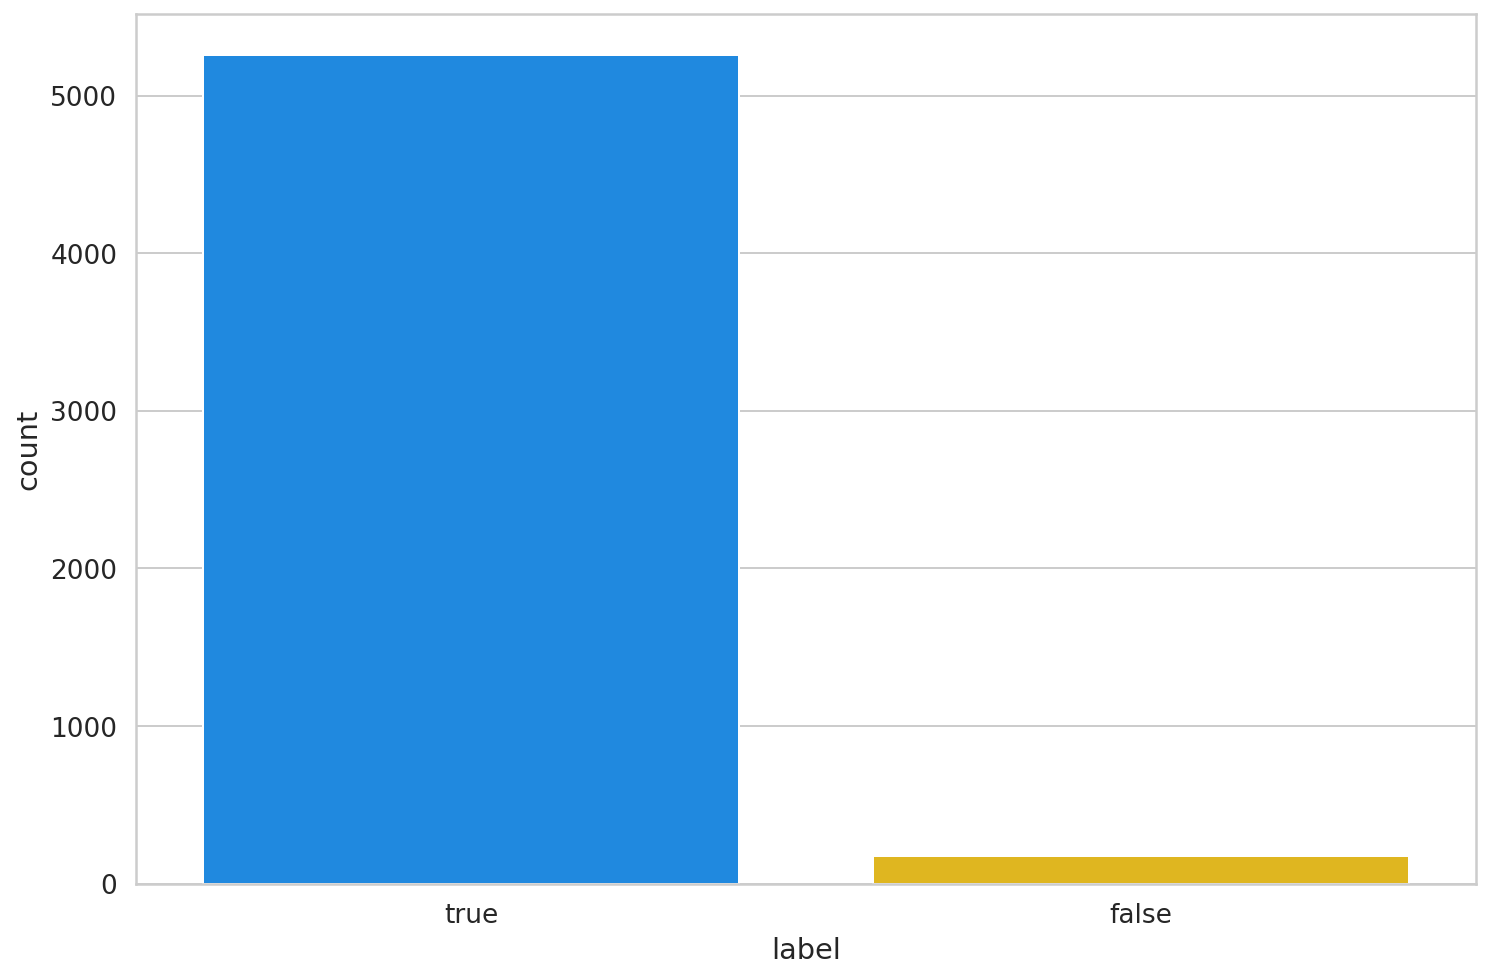

In [0]:
label_names = ['true', 'false']
ax = sns.countplot(df.label)
plt.xlabel
('labels balance')
ax.set_xticklabels(label_names);

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.
Let's use pre-trained BERT by huggingface team.

In [0]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [0]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
tokens_len = []
for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  tokens_len.append(len(tokens))

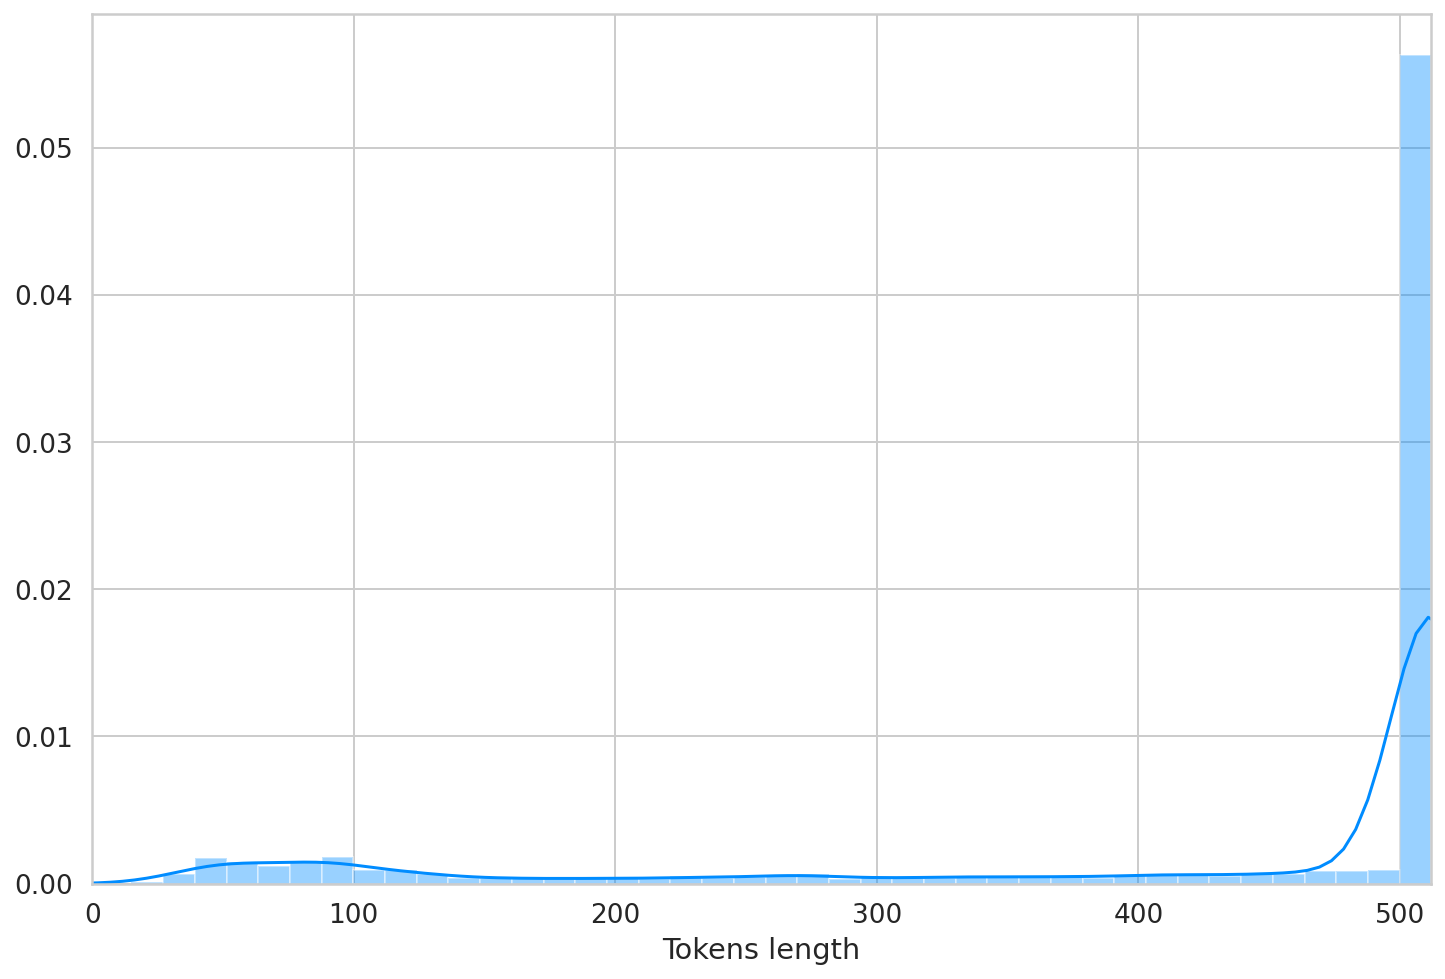

In [0]:
sns.distplot(tokens_len)
plt.xlim([0, 512]);
plt.xlabel('Tokens length');

Bert has a max length limit of tokens = 512, so in our case we will be used this limit and set max length to first 512 tokens. 

# Bert special tokens

We are required to:

*   Add special tokens to the start and end of each sentence.
*   Pad & truncate all sentences to a single constant length.
*   Explicitly differentiate real tokens from padding tokens with the "attention mask".

**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output.

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))



Splitting a dataset to train, test, and validation

In [0]:
class NewsDataset(Dataset):
  def __init__(self, text, label, tokenizer, max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    label = self.label[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.long)
    }

In [0]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [0]:
df_train.shape, df_val.shape, df_test.shape

((4344, 2), (543, 2), (543, 2))

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = NewsDataset(
    text = df.text.to_numpy(),
    label = df.label.to_numpy(),
    tokenizer = tokenizer,
    max_len = max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [0]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [0]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'label'])

In [0]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


# LabelClassifier

In [0]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
class LabelClassifier(nn.Module):
  def __init__(self, n_classes):
    super(LabelClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [0]:
model = LabelClassifier(len(label_names))
model = model.to(device)

In [0]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 512])
torch.Size([16, 512])


# Helper functions and model training loop

In [0]:
EPOCHS = 20
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [0]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    label = d["label"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, label)
    correct_predictions += torch.sum(preds == label)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, label)
      correct_predictions += torch.sum(preds == label)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------
Train loss 0.15646202595192282 accuracy 0.9652394106813996
Val   loss 0.21347355845329516 accuracy 0.9594843462246777

Epoch 2/20
----------
Train loss 0.1532727986546781 accuracy 0.9682320441988951
Val   loss 0.20090948209604798 accuracy 0.9594843462246777

Epoch 3/20
----------
Train loss 0.15408187953974395 accuracy 0.9682320441988951
Val   loss 0.19879998959710493 accuracy 0.9594843462246777

Epoch 4/20
----------
Train loss 0.15148166064446902 accuracy 0.9682320441988951
Val   loss 0.19520118791500435 accuracy 0.9594843462246777

Epoch 5/20
----------
Train loss 0.15329414545832312 accuracy 0.9682320441988951
Val   loss 0.20082252069979029 accuracy 0.9594843462246777

Epoch 6/20
----------
Train loss 0.15103854574537015 accuracy 0.9670810313075506
Val   loss 0.1989714776932755 accuracy 0.9594843462246777

Epoch 7/20
----------
Train loss 0.14384149710702546 accuracy 0.9668508287292819
Val   loss 0.1596325706307064 accuracy 0.9594843462246777

Epoch 8/20
-----

Plotting the training vs validation accuracy

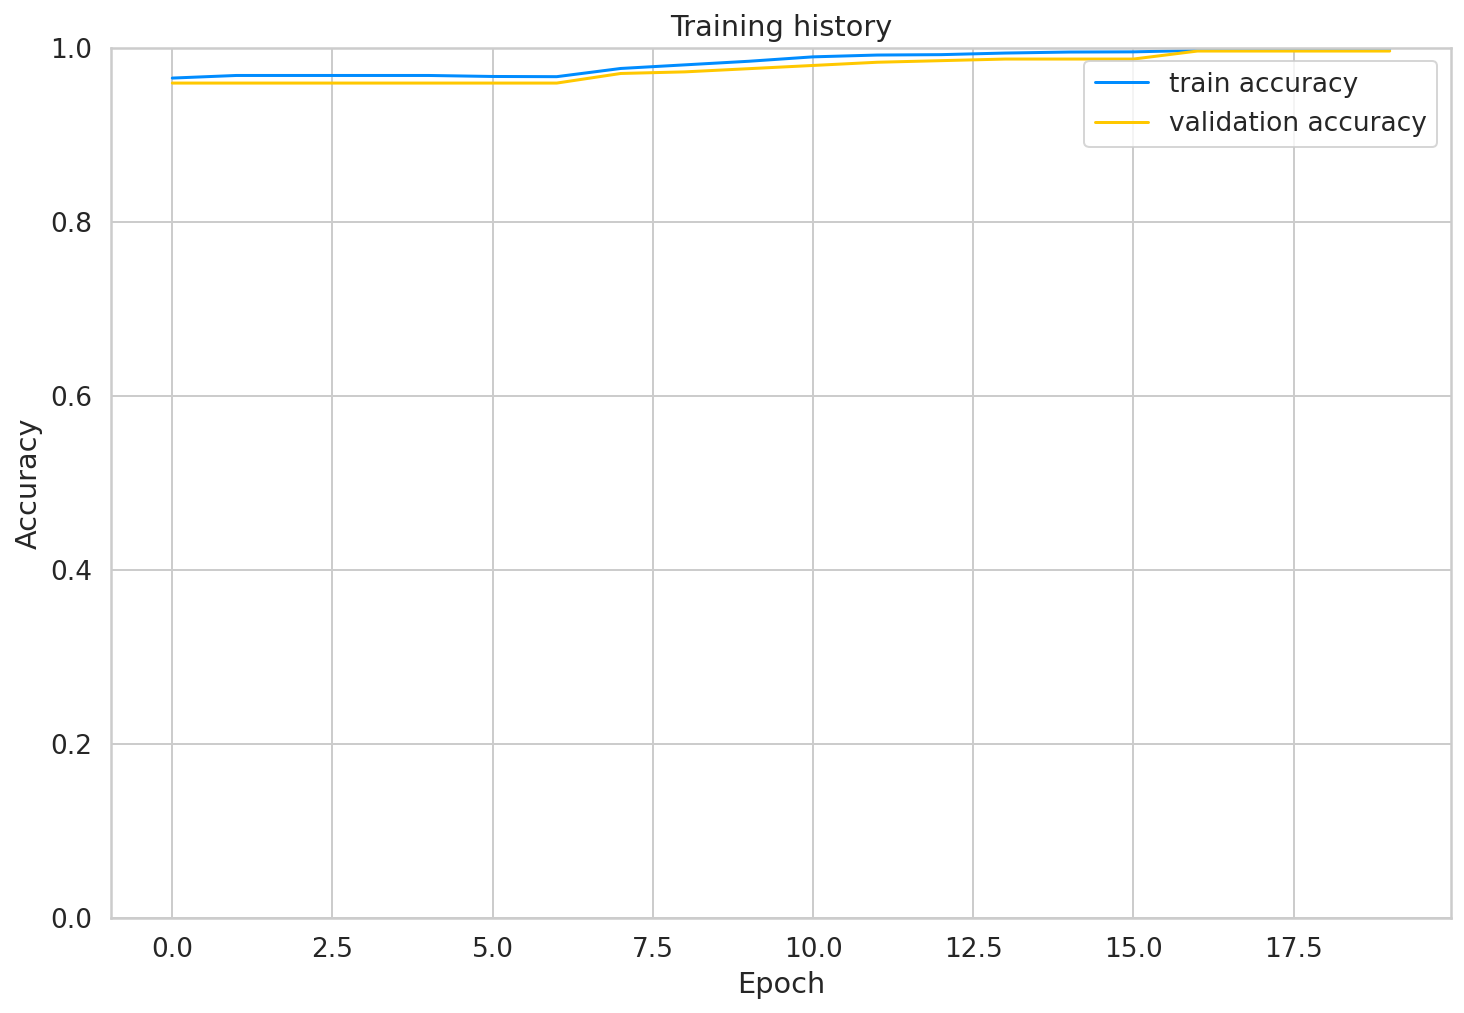

In [0]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Let's view the summary of the training process

In [0]:
model = LabelClassifier(len(label_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Calculating the accuracy on the test data:

In [0]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.994475138121547

Defining a helper function to get the predictions from our model

In [0]:
def get_predictions(model, data_loader):
  model = model.eval()
  art_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      art_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(label)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return art_texts, predictions, prediction_probs, real_values

In [0]:
y_art_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Classification report and confusion matrix

In [0]:
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

        true       1.00      1.00      1.00       530
       false       0.92      0.85      0.88        13

    accuracy                           0.99       543
   macro avg       0.96      0.92      0.94       543
weighted avg       0.99      0.99      0.99       543



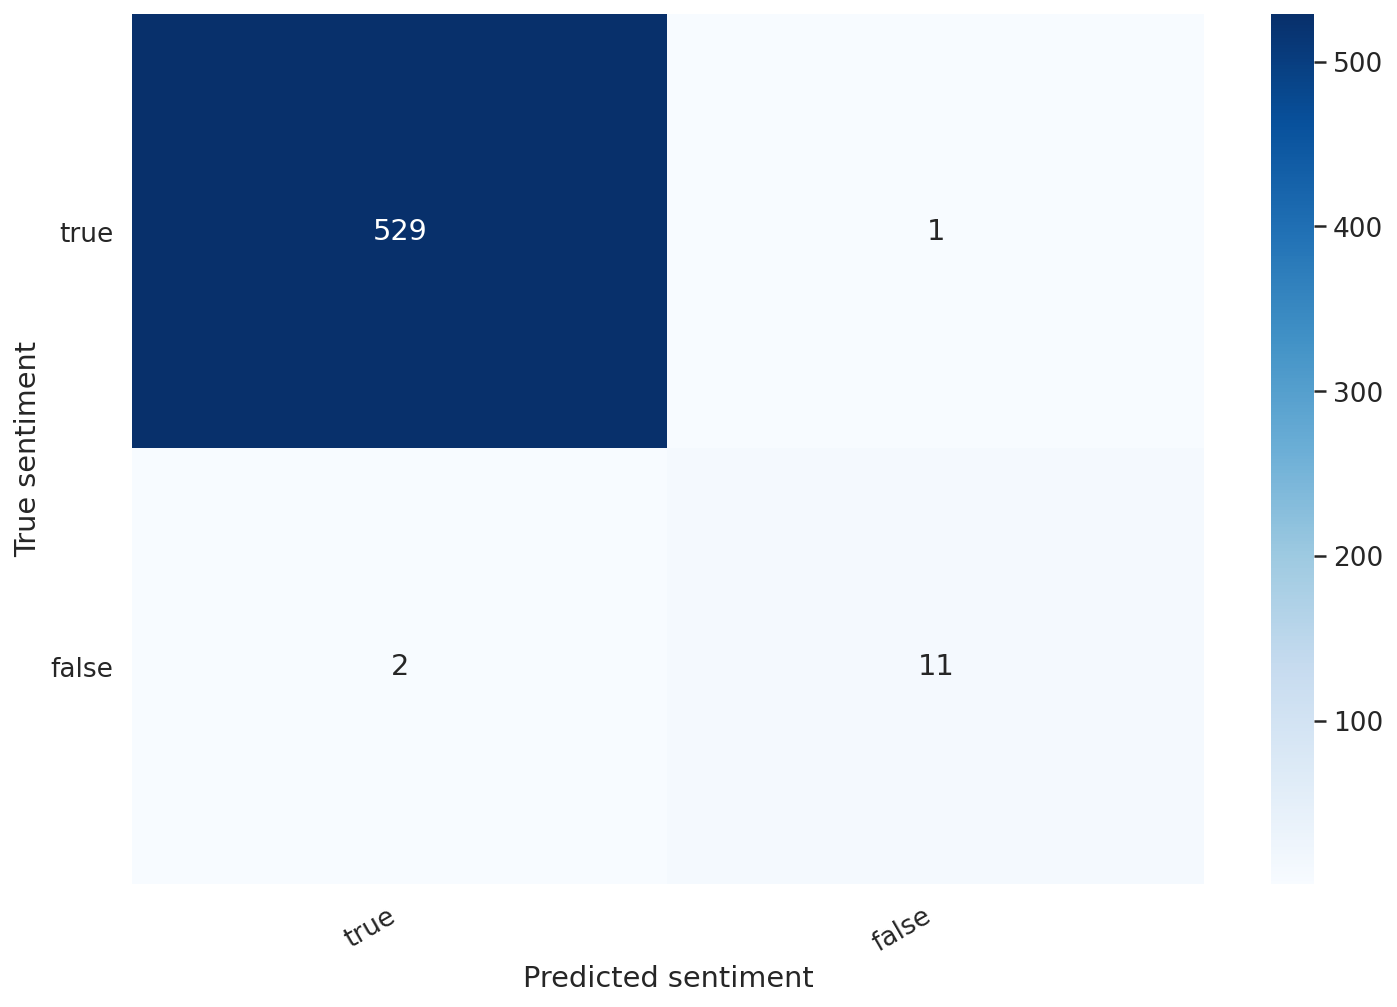

In [0]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=label_names, columns=label_names)
show_confusion_matrix(df_cm)

Best results achieved with a pre-trained BERT model, it's look good with cutting articles by BERT max tokens length (we can trying to cut not only first tokens, and some different techniks).
But like a conclusion: our basic models can get good results on this task, so if we don't need the maximum accuracy we can easely use something like logistic regression or naive bayes classifier.